In [1]:
# mamba create -n python38_ana_def python=3.8 pandas uproot matplotlib mplhep ipykernel scikit-hep pytables awkward-pandas -c conda-forge
# zfit env has to be created from scratch with zfit installed with pip at first, rest with conda (mamba)
# after that
import pandas as pd
import uproot
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mplhep as hep
plt.style.use([hep.style.CMS])

# from skhep.math.vectors import LorentzVector
import os
from os.path import join
from glob    import glob

import zfit
from hepstats.splot import compute_sweights
import tensorflow as tf

# import vector
# from tqdm.notebook import tqdm
# from tqdm import tqdm

import hist
from boost_histogram import axis

import sys
sys.path.append("/afs/cern.ch/work/s/secholak/cms/workdir/eta2mumug/python/dark_photon")
from fit_utils.plot_utils import plotFit
from fit_utils.fitter import run_minimisation



/afs/cern.ch/work/s/secholak/.conda/envs/zfit_02/lib/python3.10/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
data_path = "/eos/user/s/secholak/CMS/eta2mumug/ntuples/run3_23/merged_binned_mumu_pt_data_histos.root"
mc_templates_path = "/eos/user/s/secholak/CMS/eta2mumug/ntuples/inclusiveDiLeptonMC/full/merged/merged_templates_wohHLT_binned_mumu_pt.root"

In [3]:
def load_histos(f_path, h_names):
    histograms = {}
    with uproot.open(f_path) as tree:
        for h_name in h_names:
            histograms[h_name] = tree[h_name].to_numpy()
    
    return histograms

def load_templates_histos(f_path, t_names, bins):
    histograms = {}
    with uproot.open(f_path) as tree:
        for t_name in t_names:
            for _b in bins:
                h_name = f"{t_name}_{_b}"
                histograms[h_name] = tree[h_name].to_numpy()
    return histograms


In [4]:
template_names = [
    "isEta2MuMu",
    "isEta2MuMuGamma",
    "isOmega2Pi0MuMu",
    "isKK2mumu",
    "combinatorial"
]
bin_names = [f"{i}" for i in range(0, 40)]
data_bin_histos = load_histos(data_path, h_names = bin_names)
template_bin_histos = load_templates_histos(mc_templates_path, template_names, bin_names)

In [5]:
# file = uproot.open(mc_templates_path) 
# print(file.keys())
# data_bin_histos["0"]
# # file["0"].to_numpy()

In [6]:
from zfit import z

def fix_all_params(pdf):
    for param in pdf.get_params():
        param.floating = False

def loose_all_params(pdf):
    for param in pdf.get_params(floating=False):
        param.floating = True


class StepFunc1(zfit.pdf.ZPDF):
    _PARAMS = [
        "a0",
        "a1",

    ]

    @zfit.supports()
    def _unnormalized_pdf(self, x, params):
        """Calculate the unnormalized PDF """
        a0 = params["a0"]
        a1 = params["a1"]



        x= x[0]

        return tf.where( tf.less(x, a0), tf.constant(0.0, dtype=tf.float64),  tf.pow( x - a0, a1 ))




class TresholdFunc(zfit.pdf.ZPDF):
    _PARAMS = [
        "a0",
        "a1",
        "a2",
        "a3",
    ]

    @zfit.supports()
    def _unnormalized_pdf(self, x, params):
        """Calculate the unnormalized PDF """
        a0 = params["a0"]
        a1 = params["a1"]
        a2 = params["a2"]
        a3 = params["a3"]

        x= x[0]

        return tf.where( tf.less(x, a0), tf.constant(0.0, dtype=tf.float64),  tf.pow( x - a0, a1 )*(a2 + x*a3))




class DoubleErrFunc(zfit.pdf.ZPDF):
    """Product of two error functions"""
    _PARAMS = [
        'mean1',
        'sigma1',
        'mean2',
        'sigma2'
    ]

    @zfit.supports()
    def _unnormalized_pdf(self, x, params):  # implement function, unnormalized
        # data = x[0]  # axis 0
        data = z.unstack_x(x)
        mean1    = params['mean1']
        sigma1   = params['sigma1']
        mean2    = params['mean2']
        sigma2   = params['sigma2']

        two = tf.constant(2.0, dtype=tf.float64)

        # # First term
        term1 = (data - mean1) / (tf.sqrt(two) * sigma1)
        erf1 = 0.5 + 0.5 * tf.math.erf(term1)
    
        # Calculate the second part of the function
        term2 = (mean2 - data) / (tf.sqrt(two) * sigma2)
        erf2 = 0.5 + 0.5 * tf.math.erf(term2)

        res = erf1*erf2
        return res
    


class TanhPDF(zfit.pdf.ZPDF):
    _PARAMS = [
        "mean",
        "width"
    ]
    # def __init__(self, mean, width, name='TanhPDF'):
    #     super().__init__(name=name)
    #     self.mean = mean
    #     self.width = width
    @zfit.supports()
    def _unnormalized_pdf(self, x, params):
        """Calculate the unnormalized PDF using the hyperbolic tangent function."""

        mean  = params["mean"]
        width = params["width"]

        x = z.unstack_x(x)
        return tf.tanh((x - mean) / width)


def integral_func_tanh(x, mean, width):
    # Integrate tanh function; specific formula may vary based on your needs
    return width * (tf.atanh((x - mean) / width) + tf.constant(1.0))



class ErrorFunctionPDF(zfit.pdf.ZPDF):
    _PARAMS = [
        "mean",
        "sigma"
    ]

    @zfit.supports()
    def _unnormalized_pdf(self, x, params):
        # Define the error function formula
        # x = z.unstack_x(x)
        x = x[0]
        mean = params['mean']
        sigma = params['sigma']
        term = (x - mean) / (tf.sqrt(tf.constant(2.0, dtype=tf.float64)) * sigma)
        return 0.5 + 0.5 * tf.math.erf(term)


def errorfunction_integral(limits, params, model):
    lower, upper = limits.rect_limits[0]
    mean = params['mean']
    sigma = params['sigma']

    # Calculate z-values for the error function

    z_lower = (lower - mean) / (tf.sqrt(2.0) * sigma) if lower is not None else -float('inf')
    z_upper = (upper - mean) / (tf.sqrt(2.0) * sigma) if upper is not None else float('inf')
    # Integral using the error function evaluated at boundaries
    integral_value = 0.5 * (tf.math.erf(z_upper) - tf.math.erf(z_lower))
    
    return integral_value

integral_limits = zfit.Space(axes=(0,), limits=(zfit.Space.ANY, zfit.Space.ANY))
ErrorFunctionPDF.register_analytic_integral(
    func=errorfunction_integral,
    limits=integral_limits
    )

TanhPDF.register_analytic_integral(func=integral_func_tanh, limits=integral_limits)


In [7]:
def init_poly(obs, pdf_postfix, poly_name = 'Bernstein',
              coeffs = [
                  (0.1, -10, 10),
                  (0.1, -5, 5),
                  (0, -1, 1),
                  (0.730946, -1, 1)
              ]
               ):
    # poly = None
    coeff_list = []
    # cc is (init_val, lower_limit, upper_limit)
    for i, cc in enumerate(coeffs):
        c_name = f"c{i}_{pdf_postfix}" #each param has to have a unique name
        coeff_list.append( zfit.Parameter(c_name, cc[0], cc[1], cc[2]) )
    
    if poly_name == 'Bernstein':
        poly = zfit.pdf.Bernstein(obs, coeffs = coeff_list)
    elif poly_name == 'Chebyshev':
        poly = zfit.pdf.Chebyshev(obs, coeffs = coeff_list)
    elif poly_name == 'Legendre':
        poly = zfit.pdf.Legendre(obs, coeffs = coeff_list)
    else:
        print(f"{poly_name}  is not defined, using Chebyshev as default")
        poly = zfit.pdf.Chebyshev(obs, coeffs = coeff_list)

    return poly



def load_template_data(template_bin_histos, template_name, rebin_factor = None, range = None):
    # load histogram for a given template, transform it into a hist object, construct zfit data
    hist_values, bin_edges = template_bin_histos[template_name]

    if range is not None:
        mask = (bin_edges>=range[0]) & (bin_edges<=range[1])
        bin_edges = bin_edges[mask]
        hist_values = hist_values[mask[:-1]]

    lower_limit = bin_edges[0]
    # lower_limit = 0.212
    h = hist.Hist(hist.axis.Regular(len(bin_edges) - 1, lower_limit, bin_edges[-1], name="mumu_mass"))

    h[...] = hist_values
    # h.plot()
    if rebin_factor is not None:
        # Rebin the histogram
        h = h[::rebin_factor]
        hist_values, bin_edges = h.to_numpy()

    binned_data =  zfit.data.BinnedData.from_hist(h)

    return binned_data, hist_values, bin_edges

def load_data(data_bin_histos, bin_n, rebin_factor = None, range = None):
    # load histogram for a given bin, transform it into a hist object, construct zfit data
    hist_values, bin_edges = data_bin_histos[bin_n]
    if range is not None:
        mask = (bin_edges>=range[0]) & (bin_edges<=range[1])
        bin_edges = bin_edges[mask]
        hist_values = hist_values[mask[:-1]]

    lower_limit = bin_edges[0]
    # lower_limit = 0.212
    h = hist.Hist(hist.axis.Regular(len(bin_edges) - 1, lower_limit, bin_edges[-1], name="mumu_mass"))

    h[...] = hist_values
    # h.plot()
    if rebin_factor is not None:
        # Rebin the histogram
        h = h[::rebin_factor]
        hist_values, bin_edges = h.to_numpy()

    binned_data =  zfit.data.BinnedData.from_hist(h)

    return binned_data, hist_values, bin_edges


def get_isEta2MuMuGamma_model(bin_n, template_bin_histos, obs, obs_binned, rebin_factor):

    template_name = 'isEta2MuMuGamma_' + bin_n
    pdf_postfix = "_e2mmg_" + bin_n

    binned_data, hist_values, bin_edges =  load_template_data(template_bin_histos, template_name, rebin_factor)

    # init values and boundaries might change for different bins, this to be implemented
    poly_coeffs = [
                  (0.1, -10, 10),
                  (0.1, -5, 5),
                  (0, -1, 1),
                  (0.730946, -1, 1)
              ]
    #define expo
    c_exp = zfit.Parameter("c_exp" + pdf_postfix, -8.8, -15, -1)
    pdf_expo = zfit.pdf.Exponential(c_exp, obs)
    # define poly
    pdf_poly = init_poly(obs, pdf_postfix, poly_name = 'Bernstein',
              coeffs = poly_coeffs
               )
    # expo poly sum
    frac_exppoly = zfit.Parameter("frac_exppoly" + pdf_postfix, 0.8, 0.01, 0.99)
    pdf_poly_expo =  zfit.pdf.SumPDF([pdf_poly, pdf_expo], fracs= [frac_exppoly], obs = obs)
    # define a double errf function for multiplication
    erf_m1 = zfit.Parameter("erf_m1" + pdf_postfix, 0.215, 0.15, 0.4)

    erf_s1 = zfit.Parameter("erf_s1" + pdf_postfix, 0.004, 0.002, 0.05)
    # erf_s1.floating = False
    erf_m2 = zfit.Parameter("erf_m2" + pdf_postfix, 0.5, 0.45, 0.55)
    erf_s2 = zfit.Parameter("erf_s2" + pdf_postfix, 0.04, 0.01, 0.05)
    pdf_erf = DoubleErrFunc(obs=obs, mean1= erf_m1, sigma1= erf_s1, mean2= erf_m2, sigma2= erf_s2)
    
    # make a product of everything: it's [exp + poly] x doubleErf
    model = zfit.pdf.ProductPDF([pdf_poly_expo, pdf_erf])
    model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

    loss = zfit.loss.BinnedNLL(model_binned, binned_data)
    # minimise
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss)
    print(result)
    plotsList = {
            "data":{
                "label": "MC",
                "color": "black"
            },
            "fullmodel": {
                "label":r"$\eta \to \mu \mu \gamma$", 
                "color":"red",
            },
            
        }

    fig, ax1, ax2 = plotFit(model, (hist_values, bin_edges), plotsList, 
                    x_label="$\mu\\mu$ mass [GeV]", 
                    nbins=len(bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
                    logy = False)


    return model 

def get_isOmega2Pi0MuMu_model(bin_n, template_bin_histos, obs, obs_binned, rebin_factor):

    template_name = 'isOmega2Pi0MuMu_' + bin_n
    pdf_postfix = "_w2pi0mm_" + bin_n

    binned_data, hist_values, bin_edges =  load_template_data(template_bin_histos, template_name, rebin_factor)

    # init values and boundaries might change for different bins, this to be implemented
    poly_coeffs = [
                  (0.1, -10, 10),
                  (0.1, -5, 5),
                  (-0.3, -1, 1),
                  (0.730946, -1, 1)
              ]
    #define expo
    c_exp = zfit.Parameter("c_exp" + pdf_postfix, -8.8, -15, -1)
    pdf_expo = zfit.pdf.Exponential(c_exp, obs)
    # define poly
    pdf_poly = init_poly(obs, pdf_postfix, poly_name = 'Bernstein',
              coeffs = poly_coeffs
               )
    # expo poly sum
    frac_exppoly = zfit.Parameter("frac_exppoly" + pdf_postfix, 0.17, 0.01, 0.99)
    pdf_poly_expo =  zfit.pdf.SumPDF([pdf_poly, pdf_expo], fracs= [frac_exppoly], obs = obs)
    # define a double errf function for multiplication
    erf_m1 = zfit.Parameter("erf_m1" + pdf_postfix, 0.215, 0.15, 0.4)
    erf_s1 = zfit.Parameter("erf_s1" + pdf_postfix, 0.004, 0.002, 0.05)

    pdf_erf = ErrorFunctionPDF(obs=obs, mean= erf_m1, sigma= erf_s1)
    
    # make a product of everything: it's [exp + poly] x Erf
    model = zfit.pdf.ProductPDF([pdf_poly_expo, pdf_erf])
    model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

    loss = zfit.loss.BinnedNLL(model_binned, binned_data)
    # minimise
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss)
    print(result)
    plotsList = {
            "data":{
                "label": "MC",
                "color": "black"
            },
            "fullmodel": {
                "label": r"$\omega \to \pi^0 \mu \mu$", 
                "color":"red",
            },
            
        }

    fig, ax1, ax2 = plotFit(model, (hist_values, bin_edges), plotsList, 
                    x_label="$\mu\\mu$ mass [GeV]", 
                    nbins=len(bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
                    logy = False)
    return model 

def get_combinatorial_model(bin_n, template_bin_histos, obs, obs_binned, rebin_factor):
    

    template_name = 'combinatorial_' + bin_n
    pdf_postfix = "_comb_" + bin_n
    a0 = zfit.Parameter("a_comb_0" + pdf_postfix, 0.2113, 0.05, 0.35)
    # a1 = zfit.Parameter("a_comb_1" + pdf_postfix, 0.677493, 0.1, 0.7)
    a1 = zfit.Parameter("a_comb_1" + pdf_postfix, 0.177493, 0.1, 0.7)
    a2 = zfit.Parameter("a_comb_2" + pdf_postfix, 8.29200, 1.0, 10.0)
    a3 = zfit.Parameter("a_comb_3" + pdf_postfix, 5.46282, -10, 10.0)
    model = TresholdFunc(obs = obs, a0 = a0, a1 = a1, a2 = a2, a3 = a3 )

    # erf_m1 = zfit.Parameter("erf_m1" + pdf_postfix, 0.215, 0.15, 0.4)
    # erf_s1 = zfit.Parameter("erf_s1" + pdf_postfix, 0.004, 0.002, 0.05)
    # pdf_erf1 = ErrorFunctionPDF(obs=obs, mean= erf_m1, sigma= erf_s1)
    # # pdf_erf1 = TanhPDF(obs=obs, mean= erf_m1, width= erf_s1)

    # poly_coeffs = [
    #               (0.1, -10, 10),
    #               (3, -5, 5),
    #               (0, -1, 1),
    #               (0.730946, -1, 1)
    #           ]
    # pdf_poly = init_poly(obs, pdf_postfix, poly_name = 'Bernstein',
    #           coeffs = poly_coeffs
    #            )
    # model = zfit.pdf.ProductPDF([pdf_poly, pdf_erf1])

    binned_data, hist_values, bin_edges =  load_template_data(template_bin_histos, template_name, rebin_factor)

    model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

    loss = zfit.loss.BinnedNLL(model_binned, binned_data)
    # minimise
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss)
    print(result)
    plotsList = {
            "data":{
                "label": "MC",
                "color": "black"
            },
            "fullmodel": {
                "label": "combinatorial", 
                "color":"red",
            },
            
        }

    
    fig, ax1, ax2 = plotFit(model, (hist_values, bin_edges), plotsList, 
                    x_label="$\mu\\mu$ mass [GeV]", 
                    nbins=len(bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
                    logy = False)
    return model 

def get_isKK2MuMu_model(bin_n, template_bin_histos, obs, obs_binned, rebin_factor):
    

    template_name = 'isKK2mumu_' + bin_n
    pdf_postfix = "_kk2mm_" + bin_n

    # erf_m1 = zfit.Parameter("erf_m1" + pdf_postfix, 0.215, 0.15, 0.4)
    # erf_s1 = zfit.Parameter("erf_s1" + pdf_postfix, 0.004, 0.002, 0.05)
    # pdf_erf1 = ErrorFunctionPDF(obs=obs, mean= erf_m1, sigma= erf_s1)

    # poly_coeffs = [
    #               (0.1, -10, 10),
    #               (3, -5, 5),
    #               (0, -1, 1),
    #               (0.730946, -1, 1)
    #           ]
    # pdf_poly = init_poly(obs, pdf_postfix, poly_name = 'Bernstein',
    #           coeffs = poly_coeffs
    #            )
    # pdf_combinatorial = zfit.pdf.ProductPDF([pdf_poly, pdf_erf1])

    a0 = zfit.Parameter("a_comb_0" + pdf_postfix, 0.2113, floating=False)
    # a1 = zfit.Parameter("a_comb_1" + pdf_postfix, 0.677493, 0.1, 0.7)
    a1 = zfit.Parameter("a_comb_1" + pdf_postfix, 0.177493, 0.1, 0.7)
    a2 = zfit.Parameter("a_comb_2" + pdf_postfix, 8.29200, 1.0, 10.0)
    a3 = zfit.Parameter("a_comb_3" + pdf_postfix, 5.46282, -10, 10.0)
    pdf_combinatorial = TresholdFunc(obs = obs, a0 = a0, a1 = a1, a2 = a2, a3 = a3 )

    cb_m = zfit.Parameter("cb_m" + pdf_postfix, 3.2295e-01, 0.32, 0.35)
    cb_sigma = zfit.Parameter("cb_sigma" + pdf_postfix, 1.3348e-02, 0.01, 1.0)
    cb_alpha = zfit.Parameter("cb_alpha" + pdf_postfix, 4.4562e-01, 0, 10.0)
    cb_n = zfit.Parameter("cb_n" + pdf_postfix, 2.2148e+00, 0.1, 10.0)
    pdf_cb = zfit.pdf.CrystalBall(mu=cb_m, sigma= cb_sigma, alpha=cb_alpha, n=cb_n, obs=obs)
    frac_cb = zfit.Parameter("frac_cb" + pdf_postfix, 3.3937e-01, 0.0001, 1.0)
    model =  zfit.pdf.SumPDF([pdf_combinatorial, pdf_cb], fracs= [frac_cb], obs = obs)


    binned_data, hist_values, bin_edges =  load_template_data(template_bin_histos, template_name, rebin_factor)

    model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

    loss = zfit.loss.BinnedNLL(model_binned, binned_data)
    # minimise
    # minimizer = zfit.minimize.Minuit( gradient=False, mode = 0)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss)
    print(result)
    plotsList = {
            "data":{
                "label": "MC",
                "color": "black"
            },
            "fullmodel": {
                "label": r"KK $\to \mu \mu $", 
                "color":"red",
            },
            
        }

    
    fig, ax1, ax2 = plotFit(model, (hist_values, bin_edges), plotsList, 
                    x_label="$\mu\\mu$ mass [GeV]", 
                    nbins=len(bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
                    logy = False)
    return model 


def get_isEta2MuMu_model(bin_n, template_bin_histos, obs, obs_binned, rebin_factor, extra_postfix = None):
    

    template_name = 'isEta2MuMu_' + bin_n
    pdf_postfix = "_eta2mm_" + bin_n
    if extra_postfix is not None:
        pdf_postfix += extra_postfix
    # define CrystalBall
    cb_m = zfit.Parameter("cb_m" + pdf_postfix, 5.48204e-01, 0.53, 0.56)
    cb_sigma = zfit.Parameter("cb_sigma" + pdf_postfix, 5.20324e-03, 0.001, 0.1)
    cb_alpha = zfit.Parameter("cb_alpha" + pdf_postfix, 4.4562e-01, 0, 10.0)
    cb_n = zfit.Parameter("cb_n" + pdf_postfix, 1.00024e-01, 0.01, 10.0)
    pdf_cb = zfit.pdf.CrystalBall(mu=cb_m, sigma= cb_sigma, alpha=cb_alpha, n=cb_n, obs=obs)
    frac_gcb = zfit.Parameter("frac_gcb" + pdf_postfix, 6.94220e-01, 0.0001, 1.0)

    # define Gauss
    gs_sigma = zfit.Parameter("gs_sigma"+ pdf_postfix, 1.18375e-02, 0.001, 0.1)
    pdf_gs = zfit.pdf.Gauss(obs=obs, mu=cb_m, sigma=gs_sigma)
    # make a CB + G
    model =  zfit.pdf.SumPDF([pdf_gs, pdf_cb], fracs= [frac_gcb], obs = obs)

    binned_data, hist_values, bin_edges =  load_template_data(template_bin_histos, template_name, rebin_factor)
    model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

    loss = zfit.loss.BinnedNLL(model_binned, binned_data)
    # minimise
    # minimizer = zfit.minimize.Minuit( gradient=False, mode = 0)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss)
    print(result)
    plotsList = {
            "data":{
                "label": "MC",
                "color": "black"
            },
            "fullmodel": {
                "label": r"$\eta \to \mu \mu $", 
                "color":"red",
            },
            
        }

    
    fig, ax1, ax2 = plotFit(model, (hist_values, bin_edges), plotsList, 
                    x_label="$\mu\\mu$ mass [GeV]", 
                    nbins=len(bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
                    logy = False)
    return model 


def get_signal_model(signal_mean, bin_n, template_bin_histos, obs, obs_binned, rebin_factor):

    pdf_signal  = get_isEta2MuMu_model(bin_n, template_bin_histos, obs, obs_binned, rebin_factor, extra_postfix = "_sig_model")
    # find sigma / mean ratios for CB and Gauss
    res_ratio_cb = pdf_signal.models[1].params['sigma'].value().numpy() / pdf_signal.models[1].params['mu'].value().numpy()
    res_ratio_g = pdf_signal.models[0].params['sigma'].value().numpy() / pdf_signal.models[0].params['mu'].value().numpy()

    # change lower limit for the mean 
    pdf_signal.models[0].params['mu'].lower = 0.2

    # set new mean for signal pdf and scale resolutions 
    pdf_signal.models[0].params['mu'].set_value(signal_mean)
    pdf_signal.models[0].params['sigma'].set_value(signal_mean * res_ratio_cb)
    pdf_signal.models[1].params['sigma'].set_value(signal_mean * res_ratio_g)

    return pdf_signal


In [8]:
# from math import log
# def profile_param(ax, param, minimum, nll, scan_range  =None, param_values = None):
#     if scan_range is not None:
#         # x = np.logspace(log(param.lower.numpy(), 10), log(param.upper.numpy(), 10), 100)
#         x = scan_range
#     else:
#         x = np.linspace(param.lower.numpy(), param.upper.numpy(), num=50)
#     y = []
#     param.floating = False
#     print( f"Profiling parameter {param.name} in range of ({param.lower}, {param.upper} )")

#     for val in x:
#         param.set_value(val)
#         y.append(nll.value())

#     param.floating = True
#     zfit.param.set_values(nll.get_params(), minimum)
#     ax.plot(x, y, label = param.name)
#     if param_values is not None:
#         xx = param_values[param.name]
#         y1 = min(y)
#         y2 = max(y)
#         ax.plot([xx, xx], [ y1, y2], color = 'red')
#     # ax.legend(fontsize = 7)
#     ax.legend()
#     # ax.set_xlabel(param.name)
    
#     if "poi" in param.name:
#         ax.set_xscale('log')
#         # ax.set_yscale('log')
#     # plt.tight_layout()
    

#     return ax
# template_name = 'isEta2MuMuGamma_' + bin_n
# pdf_postfix = "_e2mmg"

# binned_data, hist_values, bin_edges =  load_template_data(template_bin_histos, template_name, rebin_factor)

# # init values and boundaries might change for different bins, this to be implemented
# poly_coeffs = [
#                 (0.1, -10, 10),
#                 (0.1, -5, 5),
#                 (0, -1, 1),
#                 (0.730946, -1, 1)
#             ]
# #define expo
# c_exp = zfit.Parameter("c_exp" + pdf_postfix, -8.8, -15, -1)
# pdf_expo = zfit.pdf.Exponential(c_exp, obs)
# # define poly
# pdf_poly = init_poly(obs, pdf_postfix, poly_name = 'Bernstein',
#             coeffs = poly_coeffs
#             )
# # expo poly sum
# frac_exppoly = zfit.Parameter("frac_exppoly" + pdf_postfix, 0.8, 0.01, 0.99)
# pdf_poly_expo =  zfit.pdf.SumPDF([pdf_poly, pdf_expo], fracs= [frac_exppoly], obs = obs)
# # define a double errf function for multiplication
# erf_m1 = zfit.Parameter("erf_m1" + pdf_postfix, 0.225, 0.2, 0.3)

# erf_s1 = zfit.Parameter("erf_s1" + pdf_postfix, 0.004, 0.002, 0.05)
# # erf_s1.floating = False
# erf_m2 = zfit.Parameter("erf_m2" + pdf_postfix, 0.5, 0.45, 0.55)
# erf_s2 = zfit.Parameter("erf_s2" + pdf_postfix, 0.04, 0.01, 0.05)
# pdf_erf = DoubleErrFunc(obs=obs, mean1= erf_m1, sigma1= erf_s1, mean2= erf_m2, sigma2= erf_s2)

# # make a product of everything: it's [exp + poly] x doubleErf
# model = zfit.pdf.ProductPDF([pdf_poly_expo, pdf_erf])
# model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

# loss = zfit.loss.BinnedNLL(model_binned, binned_data)
# # minimise
# minimizer = zfit.minimize.Minuit()
# result = minimizer.minimize(loss)
# print(result)
# plotsList = {
#         "data":{
#             "label": "MC",
#             "color": "black"
#         },
#         "fullmodel": {
#             "label":r"$\eta \to \mu \mu \gamma$", 
#             "color":"red",
#         },
        
#     }

# fig, ax1, ax2 = plotFit(model, (hist_values, bin_edges), plotsList, 
#                 x_label="$\mu\\mu$ mass [GeV]", 
#                 nbins=len(bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
#                 logy = False)

# fig, ax = plt.subplots()
# ax = profile_param(ax, erf_m1, result, loss, scan_range = np.linspace(0.21, 0.23, num=50))
# # ax.set_ylim(0, 0.1e6)
# ax.set_yscale('log')


In [9]:

def make_bkg_model(bin_n, rebin_factor_mc, obs, obs_binned_mc, n_evts_data):

    pdf_omega2pimumu    = get_isOmega2Pi0MuMu_model(bin_n, template_bin_histos, obs, obs_binned_mc, rebin_factor_mc)
    pdf_eta2mumugamma   = get_isEta2MuMuGamma_model(bin_n, template_bin_histos, obs, obs_binned_mc, rebin_factor_mc)
    pdf_combinatorial   = get_combinatorial_model(bin_n, template_bin_histos, obs, obs_binned_mc, rebin_factor_mc)
    pdf_kk2mumu        = get_isKK2MuMu_model(bin_n, template_bin_histos, obs, obs_binned_mc, rebin_factor_mc)
    pdf_eta2mumu      = get_isEta2MuMu_model(bin_n, template_bin_histos, obs, obs_binned_mc, rebin_factor_mc)

    

    constraints = []

    # fix all shape params 
    for pdf in [
                pdf_omega2pimumu,
                pdf_eta2mumugamma,
                pdf_combinatorial,
                pdf_kk2mumu,
                pdf_eta2mumu
                ]:
        fix_all_params(pdf)

    # loose params of eta2mumugamma tmplt
    loose_all_params(pdf_eta2mumugamma)
    loose_all_params(pdf_combinatorial)


    #compute initial normalisations for templates
    #  basically scaling up number of events by number of events in data
    templates = {}
    n_evts_mc = 0
    for tmplt_name in ["isEta2MuMuGamma","isOmega2Pi0MuMu","combinatorial","isKK2mumu","isEta2MuMu"]:
        _, h_values, _ = load_template_data(template_bin_histos, tmplt_name + "_" + bin_n, rebin_factor_mc)
        n_evts = np.sum(h_values)
        templates[tmplt_name] = {
            "nevts":n_evts
            }
        n_evts_mc+=n_evts

    # define normalisations for all bkg processes, except omega (which is linked to Eta2MuMuGamma)
    for tmplt_name in templates:
        if tmplt_name == "isOmega2Pi0MuMu": continue
        norm_init = templates[tmplt_name]["nevts"]*n_evts_data/n_evts_mc
        templates[tmplt_name]["norm_init"] = norm_init
        templates[tmplt_name]["norm_param"] = zfit.Parameter(f"norm_{tmplt_name}_{bin_n}", norm_init, norm_init/5, norm_init*5)

    # linking normalisation of eta2mumugamma with omega2pi0mumu, from MC it's 2.1 +/-0.1, but should be remeasured properly, maybe per each bin
    # adding a constraint on scaling param
    eta2omega_scale_val = 2.1
    eta2omega_scale_err = 0.1
    # should not fluctuate more than 10 sigma, hopefully
    eta2omega_scale = zfit.Parameter(f"eta2omega_scale_{bin_n}", eta2omega_scale_val, eta2omega_scale_val - 10*eta2omega_scale_err,  eta2omega_scale_val + 10*eta2omega_scale_err)
    templates["isOmega2Pi0MuMu"]["norm_param"] = zfit.ComposedParameter(f"norm_isOmega2Pi0MuMu_{bin_n}", lambda a,b: a/b, params=[templates["isEta2MuMuGamma"]["norm_param"], eta2omega_scale])
    eta2omega_scale_constr = zfit.constraint.GaussianConstraint(params=eta2omega_scale, observation=eta2omega_scale_val, uncertainty=eta2omega_scale_err)
    constraints.append(eta2omega_scale_constr)

    pdf_omega2pimumu_ext   = pdf_omega2pimumu.create_extended(templates["isOmega2Pi0MuMu"]["norm_param"])
    pdf_eta2mumugamma_ext  = pdf_eta2mumugamma.create_extended(templates["isEta2MuMuGamma"]["norm_param"])
    pdf_combinatorial_ext  = pdf_combinatorial.create_extended(templates["combinatorial"]["norm_param"])
    pdf_kk2mumu_ext        = pdf_kk2mumu.create_extended(templates["isKK2mumu"]["norm_param"])
    pdf_eta2mumu_ext       = pdf_eta2mumu.create_extended(templates["isEta2MuMu"]["norm_param"])

    bkg_list = [
        pdf_omega2pimumu_ext
        ,pdf_eta2mumugamma_ext
        ,pdf_combinatorial_ext
        ,pdf_kk2mumu_ext
        ,pdf_eta2mumu_ext
            ]

    bkg_model = zfit.pdf.SumPDF(bkg_list, obs = obs)
        
    
    return bkg_model, constraints

def do_b_only_fit(bkg_model, obs_binned, binned_data, constraints):
    bkg_model_binned =  zfit.pdf.BinnedFromUnbinnedPDF(bkg_model, obs_binned)
    loss = zfit.loss.ExtendedBinnedNLL(bkg_model_binned, binned_data, constraints = constraints)
    # minimise
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(loss)

    return result


def plot_b_only_fit(bkg_model, hist_vals, hist_bin_edges, fit_label):
    plotsList = {
        "data":{
            "label": "MC",
            "color": "black"
        },
        "fullmodel": {
            "label": fit_label, 
            "color":"red",
        },
        "model_0": {
            "label": r"$\omega \to \pi^0 \mu \mu$", 
        },
        "model_1": {
            "label": r"$\eta \to \mu \mu \gamma$", 
        },
        "model_2": {
            "label": "combinatorial", 
        },
        "model_3": {
            "label": r"$KK \to \mu \mu$", 
        },
        "model_4": {
            "label": r"$\eta \to \mu \mu$", 
        },
        
    }
        
    fig, ax1, ax2 = plotFit(bkg_model, (hist_vals, hist_bin_edges), plotsList, 
                    x_label="$\mu\\mu$ mass [GeV]", 
                    nbins=len(hist_bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
                    logy = False)
    
    return fig, ax1, ax2



def plot_sb_fit(bkg_model, hist_vals, hist_bin_edges, fit_label):
    plotsList = {
        "data":{
            "label": "MC",
            "color": "black"
        },
        "fullmodel": {
            "label": fit_label, 
            "color":"red",
        },
        # "model_0": {
        #     "label": r"$\omega \to \pi^0 \mu \mu$", 
        # },
        # "model_1": {
        #     "label": r"$\eta \to \mu \mu \gamma$", 
        # },
        # "model_2": {
        #     "label": "combinatorial", 
        # },
        # "model_3": {
        #     "label": r"$KK \to \mu \mu$", 
        # },
        # "model_4": {
        #     "label": r"$\eta \to \mu \mu$", 
        # },
        
    }
        
    fig, ax1, ax2 = plotFit(bkg_model, (hist_vals, hist_bin_edges), plotsList, 
                    x_label="$\mu\\mu$ mass [GeV]", 
                    nbins=len(hist_bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
                    logy = False)
    
    return fig, ax1, ax2

def make_sig_model(signal_mean, obs, bin_n, obs_binned, rebin_factor_mc):
    # fit to eta2mumu peak in that bin, use that model with modified mean and sigma as signal

    sig_model = get_signal_model(signal_mean, bin_n, template_bin_histos, obs, obs_binned, rebin_factor_mc)
    fix_all_params(sig_model)

    return sig_model


/afs/cern.ch/work/s/secholak/.conda/envs/zfit_02/lib/python3.10/site-packages/zfit/core/loss.py:325: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['inconsistent_fitrange'] = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
PDFs [<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f46869b0ee0>] as well as `data` [<zfit._data.binneddatav1.BinnedData object at 0x7f46869ab4f0>] have different ranges [(<zfit Space obs=('mumu_mass',), axes=None, limits=(array([[0.2]]), array([[0.6]])), binned=True>, <zfit Space obs=('mumu_mass',), axes=None, limits=(array([[0.2]]), array([[0.6]])), binned=True>)] they are defined in. The data range will cut the data while the norm range defines the normalization.
  warn_advanced_feature(


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f46869b0ee0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f46869ab4f0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00035 │            351.56 | -216.018 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                       value  (rounded)    at limit
-----------------------  ------------------  ----------
frac_exppoly_w2pi0mm_19           0.0572899       False
c0__w2pi0mm_19                     0.274319       False
c1__w2pi0mm_19                     0.571599       False
c2__w2pi0mm_19                    -0.386817       False
c3

/tmp/secholak/ipykernel_2504074/2730441088.py:57: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  pdf_omega2pimumu_ext   = pdf_omega2pimumu.create_extended(templates["isOmega2Pi0MuMu"]["norm_param"])
/tmp/secholak/ipykernel_2504074/2730441088.py:58: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  pdf_eta2mumugamma_ext  = pdf_eta2mumugamma.create_extended(templates["isEta2MuMuGamma"]["norm_param"])


FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f461b9ecc70>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f461b9ec6d0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00012 │            46.16 |  12873.84 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                            value  (rounded)    at limit
----------------------------  ------------------  ----------
frac_gcb_eta2mm_19_sig_model            0.419566       False
cb_m_eta2mm_19_sig_model                0.548554       False
gs_sigma_eta2mm_19_sig_model           0.0117591       False
cb_sigma_eta2mm_19_sig_model     

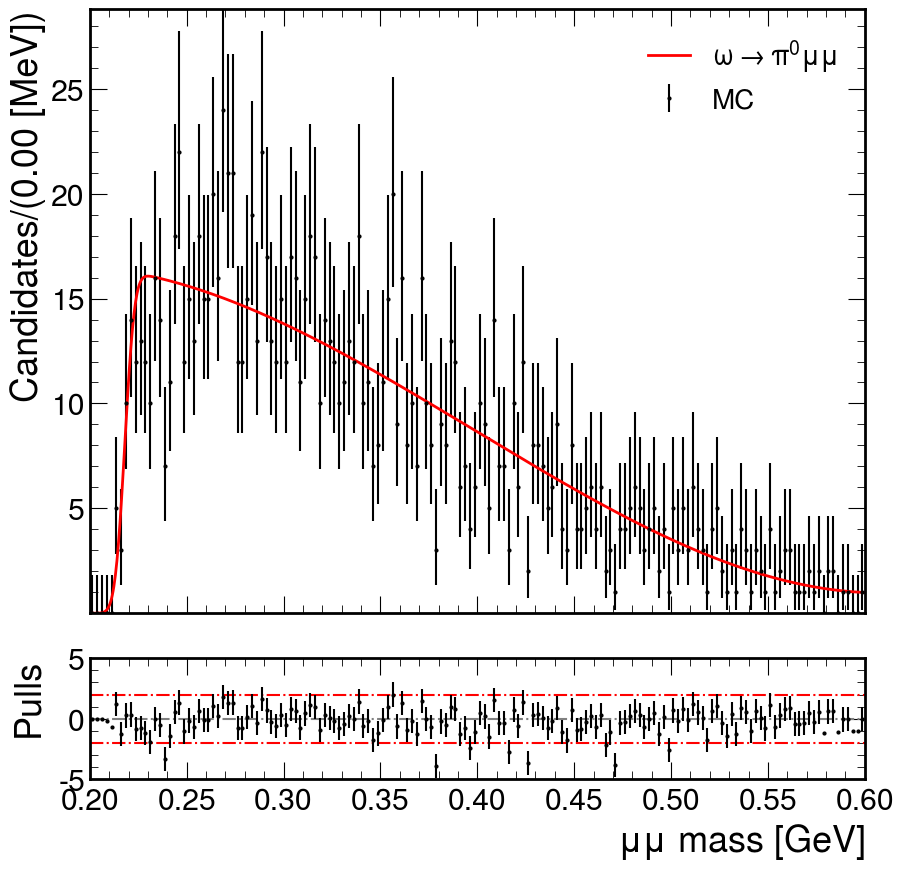

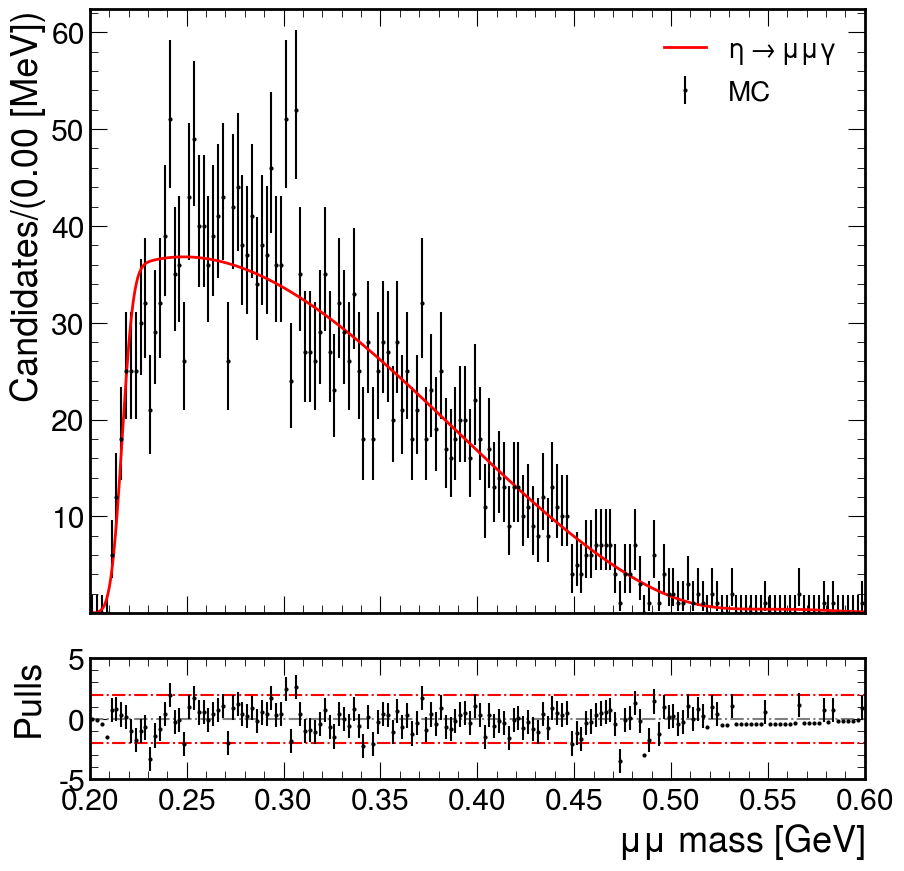

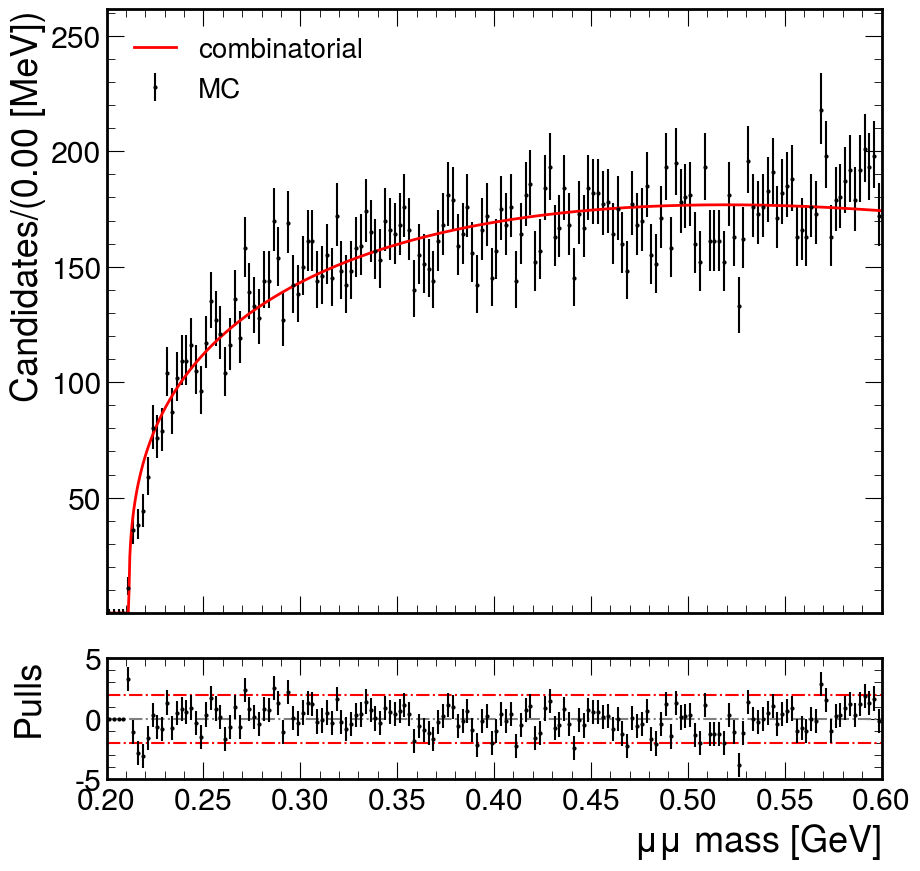

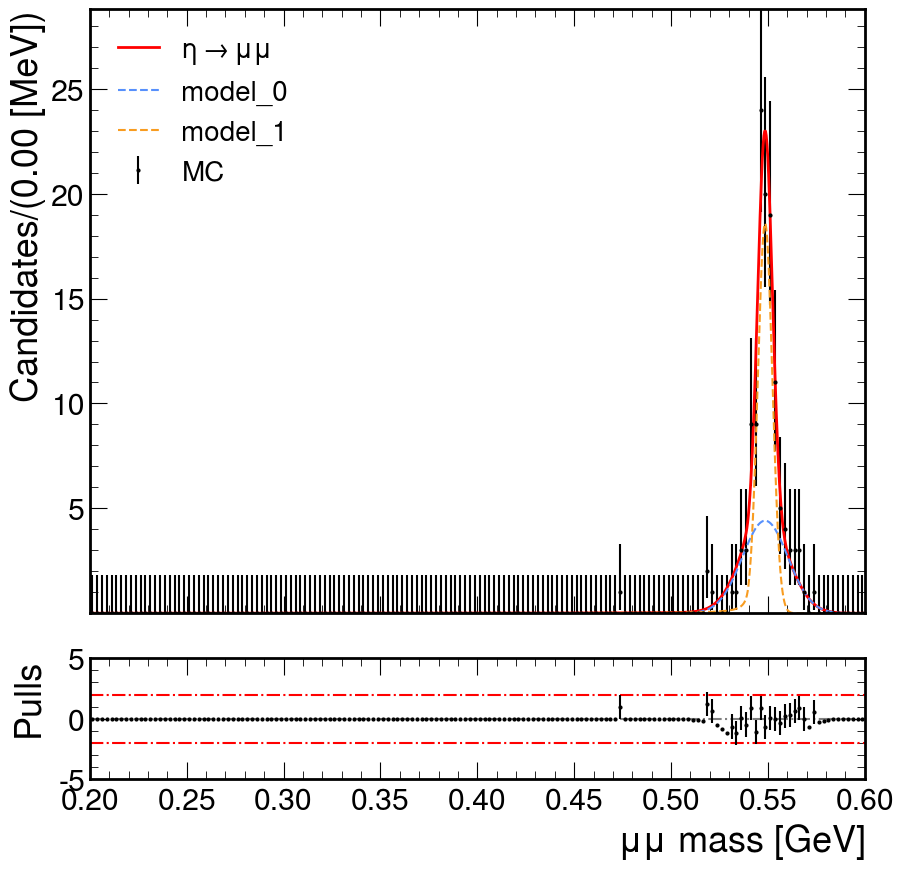

In [10]:
bin_n = "19"
rebin_factor_mc = 5j #imaginary number
rebin_factor_dat = 2j
# rebin_factor_mc = None #imaginary number
# load any template to initialize binning and obs
template_name = 'isEta2MuMu_0'
binned_d, hist_values, bin_edges = load_template_data(template_bin_histos, template_name, rebin_factor_mc)

lower_limit = bin_edges[0]
binning = zfit.binned.RegularBinning(len(bin_edges) - 1,  lower_limit, bin_edges[-1], name="mumu_mass")
obs_binned_mc = zfit.Space("mumu_mass", binning=binning)
obs = zfit.Space("mumu_mass", limits = (lower_limit, bin_edges[-1]))
# try to fit templates to a binned dataset
    # load data for the given bin
binned_z_data, d_h_vals, d_bin_edges = load_data(data_bin_histos, bin_n, rebin_factor = rebin_factor_dat)
# needed for upper limits on counting params
n_evts_data = np.sum(d_h_vals)

lower_limit_data = d_bin_edges[0]
binning_data = zfit.binned.RegularBinning(len(d_bin_edges) - 1,  lower_limit_data, d_bin_edges[-1], name="mumu_mass")
obs_binned_data = zfit.Space("mumu_mass", binning=binning_data)

bkg_model, constraints = make_bkg_model(bin_n, rebin_factor_mc, obs, obs_binned_mc, n_evts_data)
minimum = do_b_only_fit(bkg_model, obs_binned_data, binned_z_data, constraints)

# prefit_label = "prefit" # if run without minimising b model
prefit_label = "bkg only fit"

fig, ax1, ax2 = plot_b_only_fit(bkg_model, d_h_vals, d_bin_edges, fit_label = prefit_label)


signal_mean = 0.3
sig_model = make_sig_model(signal_mean, obs, bin_n, obs_binned_mc, rebin_factor_mc)
# do bkg only, the sig+bkg fit
# then Asymptotic fit
# then multibin fit and limit


In [11]:
sig_norm = zfit.Parameter(f"signal_norm_{bin_n}", 0, -100, 100)
sig_model_ext = sig_model.create_extended(sig_norm)
sb_model =  zfit.pdf.SumPDF([sig_model_ext, bkg_model], obs = obs)

In [12]:
# zfit.run.clear_graph_cache()
sb_model_binned =  zfit.pdf.BinnedFromUnbinnedPDF(sb_model, obs_binned_data)
loss = zfit.loss.ExtendedBinnedNLL(sb_model_binned, binned_z_data, constraints = constraints)
# minimise
# minimizer = zfit.minimize.Minuit()
from zfit.minimize import DefaultToyStrategy  
minimizer = zfit.minimize.Minuit(strategy=DefaultToyStrategy())
result_sb = minimizer.minimize(loss)

/afs/cern.ch/work/s/secholak/.conda/envs/zfit_02/lib/python3.10/site-packages/zfit/minimizers/strategy.py:109: RuntimeWarning: Could not calculate fminfull due to 'NoneType' object has no attribute 'value'. Setting to 0. This is a new feature and is caught to not break backwards compatibility.
  super().__init__()
/afs/cern.ch/work/s/secholak/.conda/envs/zfit_02/lib/python3.10/site-packages/zfit/minimizers/baseminimizer.py:206: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.strategies_in_minimizers. = False`  or 'all' with `zfit.settings.changed_warnings.all = False
A strategy should now be a class, not an instance. The minimizer will at the beginning of the minimization create an instance that can be stateful during the minimization and will be stored in the FitResult.
  warn_changed_feature(


/afs/cern.ch/work/s/secholak/.conda/envs/zfit_02/lib/python3.10/site-packages/zfit/minimizers/baseminimizer.py:530: FutureWarning: recovering result, yet no special functionality implemented yet.
  result = self._recover_result(prelim_result=prelim_result)


In [ ]:
print(result_sb)

FitResult of
<ExtendedBinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f46869de530>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f46869aba30>] constraints=[<zfit.core.constraint.GaussianConstraint object at 0x7f4684083d30>]> 
with
None

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════╡
│  False  │    False    │       True       │       │                   nan | None │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════╛

Parameters
name                       value  (rounded)    at limit
-----------------------  ------------------  ----------
signal_norm_19                     -66.6775       False
norm_isEta2MuMuGamma_19              133650       False
eta2omega_scale_19                  2.10816       False
norm_combinator

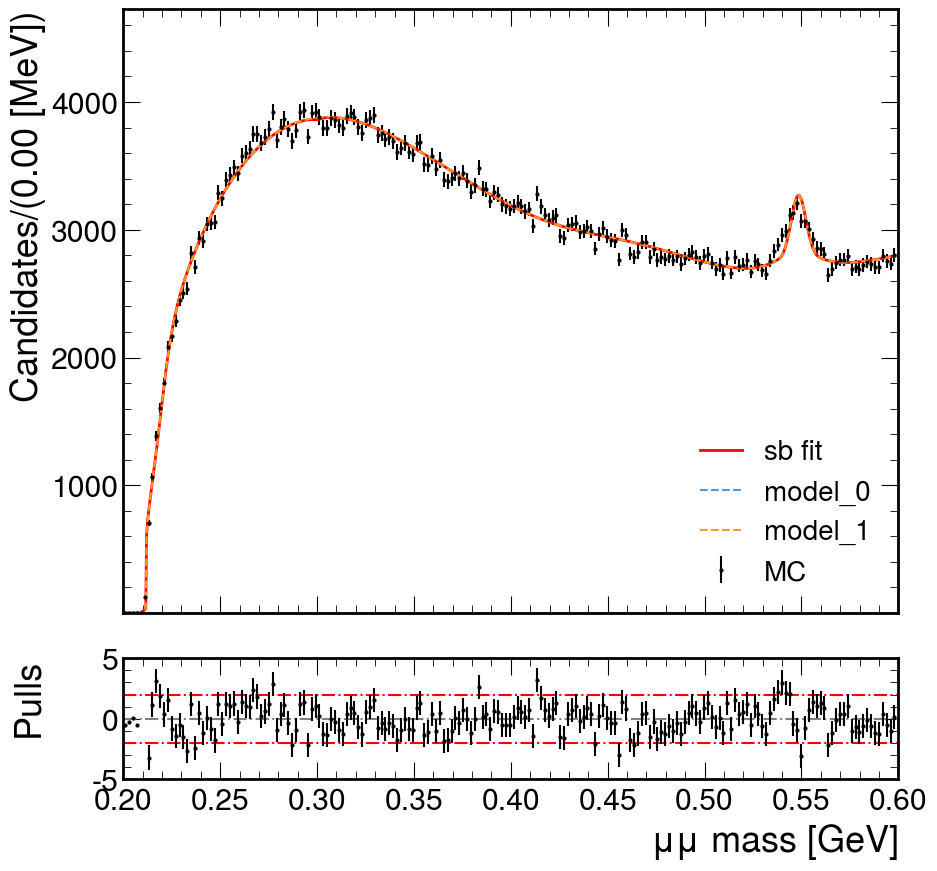

In [14]:
_, _,_ = plot_sb_fit(sb_model, d_h_vals, d_bin_edges, fit_label = "sb fit")

In [15]:
from hepstats.hypotests import UpperLimit
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests.parameters import POI, POIarray


# instantation of the calculator
calculator = AsymptoticCalculator(loss, minimizer)
calculator.bestfit = result_sb  # optionnal

# parameter of interest of the null hypothesis
poinull = POIarray(sig_norm, np.linspace(0, 10, 20))
# parameter of interest of the alternative hypothesis
poialt = POI(sig_norm, 0)

# instantation of the discovery test
ul = UpperLimit(calculator, poinull, poialt)

ul.upperlimit(alpha=0.05, CLs=True)


/afs/cern.ch/work/s/secholak/.conda/envs/zfit_02/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/afs/cern.ch/work/s/secholak/.conda/envs/zfit_02/lib/python3.10/site-packages/zfit/minimizers/baseminimizer.py:530: FutureWarning: recovering result, yet no special functionality implemented yet.
  result = self._recover_result(prelim_result=prelim_result)


KeyboardInterrupt: 

In [15]:
# plot_scaling = n_evts_data / (len(d_bin_edges) -1) * obs.volume

# # d_h_vals, d_bin_edges
# x = np.linspace(obs.v1.lower, obs.v1.upper,  len(d_bin_edges) -1)


# plt.figure()
# # plt.title(title)
# y = bkg_model.pdf(x)
# # y_doublecb = doublecb.pdf(x) * model.pdfs[0].params["frac_0"]
# # y_exp = exponential.pdf(x) * model.pdfs[0].params["frac_1"]
# plt.plot(x, y * plot_scaling, label="Sum - Binned Model")
# # plt.plot(x, y_doublecb * plot_scaling, label="Gauss - Signal")
# # plt.plot(x, y_exp * plot_scaling, label="Exp - Background")
# # mplhep.histplot(np.histogram(data_np, bins=n_bins), yerr=True, color='black', histtype='errorbar')
# # mplhep.histplot(data, yerr=data.counts() ** 0.5, color="black", histtype="errorbar")
# bin_dat.to_hist().plot(density=None)
# plt.ylabel("Counts")
# plt.xlabel("obs: $B_{mass}$")
# plt.legend()

In [16]:
# # Model development for eta2mumugamma
# def init_model(obs, pdf_postfix, model_combination = "threshold_poly_expo"):

#     model = None

#     if model_combination == "threshold_poly_expo":
#         c0 = zfit.Parameter("c0_"+ pdf_postfix, 0.1, -10, 10)
#         c1 = zfit.Parameter("c1_"+ pdf_postfix, 0.1, -5, 5)
#         c2 = zfit.Parameter("c2_"+ pdf_postfix, 0, -1, 1)
#         c3 = zfit.Parameter("c3_"+ pdf_postfix, 0.730946, -1, 1)



#         # pdf_poly = zfit.pdf.Bernstein(obs, c0_bernst, c1_bernst )
#         # pdf_poly = zfit.pdf.Legendre(obs, c0_bernst, c1_bernst )
#         pdf_poly = zfit.pdf.Bernstein(obs, 
#                                     coeffs=[
#                                         c0, 
#                                         c1, 
#                                         # c2, 
#                                         # c3
#                                         ])



#         #define expo
#         c_exp = zfit.Parameter("c_exp" + pdf_postfix, -8.8, -15, -1)
#         pdf_expo = zfit.pdf.Exponential(c_exp, obs)

#         # expo bernstein sum
#         frac_expBern_e2mmg = zfit.Parameter("frac_expBern" + pdf_postfix, 0.8, 0.01, 0.99)
#         pdf_poly_expo =  zfit.pdf.SumPDF([pdf_poly, pdf_expo], fracs= [frac_expBern_e2mmg], obs = obs)

#         # define a double errf function for multiplication
#         erf_m1 = zfit.Parameter("erf_m1" + pdf_postfix, 0.215, 0.15, 0.4)
#         erf_s1 = zfit.Parameter("erf_s1" + pdf_postfix, 0.004, 0.002, 0.05)
#         # erf_s1.floating = False
#         erf_m2 = zfit.Parameter("erf_m2" + pdf_postfix, 0.5, 0.45, 0.55)
#         erf_s2 = zfit.Parameter("erf_s2" + pdf_postfix, 0.04, 0.01, 0.05)

#         pdf_erf = DoubleErrFunc(obs=obs, mean1= erf_m1, sigma1= erf_s1, mean2= erf_m2, sigma2= erf_s2)
#         # two separate errf do not converge well
#         # pdf_erf1 = ErrorFunctionPDF(obs=obs, mean= erf_m1, sigma= erf_s1)
#         # pdf_erf2 = ErrorFunctionPDF(obs=obs, mean= erf_m2, sigma= erf_s2)

#         # tanh gives NaNs in loss
#         # pdf_tanh1 = TanhPDF(obs=obs, mean= erf_m1, width= erf_s1)
#         # pdf_tanh2 = TanhPDF(obs=obs, mean= erf_m2, width= erf_s2)
        

#         # make a product of everything
#         model = zfit.pdf.ProductPDF([pdf_poly_expo, pdf_erf]) 
#         # model = zfit.pdf.ProductPDF([pdf_poly_expo, pdf_erf1, pdf_erf2]) 
#         # model = zfit.pdf.ProductPDF([pdf_poly_expo, pdf_erf1, pdf_tanh2]) 



#     elif model_combination == "convolution":
#         # try convolution, not finished
#         pdf_kenel = zfit.pdf.Gauss(mu = erf_m1, sigma= erf_s1, obs=obs)
#         model = zfit.pdf.FFTConvPDFV1(func=pdf_poly_expo, kernel=pdf_kenel)

#     elif model_combination == "gauss_double_expo":
#         # try an alternative function like gauss and expo tails (Landau?)
#         mu = zfit.Parameter("mu" + pdf_postfix, 0.215, 0.15, 0.4)
#         sigmal =  zfit.Parameter("sigmal" + pdf_postfix, 0.1, 0.01, 0.5)
#         alphal =  zfit.Parameter("alphal" + pdf_postfix, 1,0.0001, 10)
#         alphar =  zfit.Parameter("alphar" + pdf_postfix, 1, 0.0001, 5)
#         sigmar =  zfit.Parameter("sigmar" + pdf_postfix, 0.215, 0.001, 0.4)
#         model = zfit.pdf.GeneralizedGaussExpTail(mu = mu, sigmal = sigmal, alphal = alphal, alphar = alphar, sigmar = sigmar, obs = obs)
#     elif model_combination == "CB":
        
#         mu = zfit.Parameter("mu" + pdf_postfix, 0.215, 0.15, 0.4)
#         sigma =  zfit.Parameter("sigma" + pdf_postfix, 0.1, 0.01, 0.5)
#         alpha =  zfit.Parameter("alpha" + pdf_postfix, 1, 0.01, 5)
#         n =  zfit.Parameter("n" + pdf_postfix, 0.1, 0.001, 10)
#         model = zfit.pdf.CrystalBall(mu=mu, sigma= sigma, alpha=alpha, n=n, obs=obs)
   
#     elif model_combination == "doubleCB":
#         # name            value  (rounded)    at limit
#         # ------------  ------------------  ----------
#         # mu_e2mmg                0.234792       False
#         # sigma_e2mmg            0.0110054       False
#         # alphal_e2mmg             9.99667       False
#         # nl_e2mmg                 8.11826       False
#         # alphar_e2mmg            0.133345       False
#         # nr_e2mmg                 99.9978       False
#         mu = zfit.Parameter("mu" + pdf_postfix, 0.235, 0.2, 0.25)
#         sigma =  zfit.Parameter("sigma" + pdf_postfix, 0.01, 0.001, 0.05)
#         alphal =  zfit.Parameter("alphal" + pdf_postfix, 10,0.0001, 20)
#         alphar =  zfit.Parameter("alphar" + pdf_postfix, 0.1, 0.0001, 5)
#         nl =  zfit.Parameter("nl" + pdf_postfix, 8, 0.001, 10)
#         nr =  zfit.Parameter("nr" + pdf_postfix, 10, 0.001, 100)
#         pdf_cb = zfit.pdf.DoubleCB(mu = mu,  sigma = sigma,  alphal = alphal,  alphar = alphar,  nl  = nl, nr = nr, obs=obs )

#         erf_m2 = zfit.Parameter("erf_m2" + pdf_postfix, 0.5, 0.48, 0.55)
#         erf_s2 = zfit.Parameter("erf_s2" + pdf_postfix, 0.04, 0.01, 0.05)
#         pdf_erf2 = ErrorFunctionPDF(obs=obs, mean= erf_m2, sigma= erf_s2)

#         # mu_g = zfit.Parameter("mu_g" + pdf_postfix, 0.215, 0.15, 0.4)
#         mu_g = zfit.Parameter("mu_g" + pdf_postfix, 0, floating = False)
#         sigma_g =  zfit.Parameter("sigma_g" + pdf_postfix, 0.1, 0.01, 0.5)
#         pdf_g = zfit.pdf.Gauss(mu = mu_g, sigma = sigma_g, obs = obs)

#         # model = zfit.pdf.FFTConvPDFV1(func = pdf_cb, kernel = pdf_g)
#         # model = zfit.pdf.ProductPDF([pdf_cb, pdf_erf2])

#         model = pdf_cb


#     return model



# # load histogram for a given template, transform it into a hist object, construct zfit data
# hist_values, bin_edges = template_bin_histos['isEta2MuMuGamma_1']
# lower_limit = bin_edges[0]
# # lower_limit = 0.212
# h = hist.Hist(hist.axis.Regular(len(bin_edges) - 1, lower_limit, bin_edges[-1], name="mumu_mass"))

# h[...] = hist_values
# # h.plot()

# binned_data =  zfit.data.BinnedData.from_hist(h)
# binning = zfit.binned.RegularBinning(len(bin_edges) - 1,  lower_limit, bin_edges[-1], name="mumu_mass")
# obs_binned = zfit.Space("mumu_mass", binning=binning)
# obs = zfit.Space("mumu_mass", limits = (lower_limit, bin_edges[-1]))

# # norm = zfit.Parameter("norm", np.sum(hist_values))

# pdf_postfix = "_e2mmg"

# model = init_model(obs, pdf_postfix, model_combination = "threshold_poly_expo")
# model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

# loss = zfit.loss.BinnedNLL(model_binned, binned_data)


# # minimise
# from zfit.minimize import DefaultToyStrategy  
# # minimizer = zfit.minimize.Minuit(strategy=DefaultToyStrategy(), gradient=False, mode = 0)
# minimizer = zfit.minimize.Minuit( gradient=False, mode = 0)
# result = minimizer.minimize(loss)
# print(result)

# # plot
# # binned_data.to_hist().plot(density=1)
# # model_binned.to_hist().plot(density=1)
# # plt.yscale('log')
# # plt.ylim(1e-2, 15)

# plotsList = {
#             "data":{
#                 "label": "Data",
#                 "color": "black"
#             },
#             "fullmodel": {
#                 "label": "Full fit", 
#                 "color":"red",
#             },
            
#             # "model_0": {
#             #     # "label": f"Double Gaussian, N = {nsig1:.1f}+/-{nsig1_err:.1f}\n mu, sigma = {zfit.run(mu_sig_1):.1f}, {zfit.run(sigma_sig_1):.1f}", 
#             #     "label": f"{sig_pdf_type},\n N = {nsig:.1f}+/-{nsig_err:.1f}", 
#             #     "color":"green",
#             # },
#         }

# fig, ax1, ax2 = plotFit(model, (hist_values, bin_edges), plotsList, 
#                     x_label="$\mu\\mu$ mass [GeV]", 
#                     nbins=len(bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
#                     logy = False)

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7fb02c8f1690>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7fb02c91d7b0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  False  │    True     │       True       │ 5.5e-05 │          1517.48 | -13080.81 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                  value  (rounded)    at limit
------------------  ------------------  ----------
frac_expBern_e2mmg           0.0164099       False
c0__e2mmg                     0.100012       False
c1__e2mmg                   -0.0763285       False
c_exp_e2mmg                   -8.79947       False
erf_m1_e2mmg                  0.

In [17]:
# for model in zfit.pdf.__all__:
#     print(model)


BasePDF
BaseFunctor
Exponential
Voigt
CrystalBall
DoubleCB
GeneralizedCB
GaussExpTail
GeneralizedGaussExpTail
Gauss
BifurGauss
Uniform
TruncatedGauss
WrapDistribution
Cauchy
Poisson
QGauss
ChiSquared
StudentT
Gamma
JohnsonSU
Bernstein
Chebyshev
Legendre
Chebyshev2
Hermite
Laguerre
RecursivePolynomial
ProductPDF
SumPDF
GaussianKDE1DimV1
KDE1DimGrid
KDE1DimExact
KDE1DimFFT
KDE1DimISJ
FFTConvPDFV1
ConditionalPDFV1
ZPDF
SimplePDF
SimpleFunctorPDF
UnbinnedFromBinnedPDF
BinnedFromUnbinnedPDF
HistogramPDF
SplineMorphingPDF
BinwiseScaleModifier
BinnedSumPDF
BaseBinnedFunctorPDF
BaseBinnedPDF
SplinePDF
TruncatedPDF
LogNormal
CachedPDF


In [18]:


# # try again theoretically inspired functions


# class Eta2MuMuGammaPDF(zfit.pdf.ZPDF):
#     _PARAMS = [
#         "a01",
#         "a02",
#         "a03",
#         "a04",
#         "a05",
#         "a06"
#     ]

#     @zfit.supports()
#     def _unnormalized_pdf(self, x, params):
#         """Calculate the unnormalized PDF """

#         a01 = params["a01"]
#         a02 = params["a02"]
#         a03 = params["a03"]
#         a04 = params["a04"]
#         a05 = params["a05"]
#         a06 = params["a06"]

#         # x = z.unstack_x(x)
#         x= x[0]
#         # term1 = 1 / tf.pow(x, a06)
#         # term2 = 1 + a01 / tf.pow(x, 2)
#         # term3 = tf.sqrt(1 - a02 / tf.pow(x, 2))
#         # term4 = tf.pow(1 - tf.pow(x, 2) * a04, a03)
#         # term5 = tf.pow(1 - tf.pow(x, 2) / tf.pow(a05, 2), -2)

#         # product = term1 * term2 * term3 * term4 * term5
#         # expr = tf.where( x < 0.53, product, 0)
#         # expr = (1 / x**a06) * (1 + a01 / (x**2)) * ((1 - a02 / (x**2))**0.5) * ((1 - x**2 * a04)**a03) * ((1 - x**2 / a05**2)**-2)

#         return 1 / tf.pow(x, a06)



# # load histogram for a given template, transform it into a hist object, construct zfit data
# hist_values, bin_edges = template_bin_histos['isEta2MuMuGamma_0']
# lower_limit = bin_edges[0]
# # lower_limit = 0.212
# h = hist.Hist(hist.axis.Regular(len(bin_edges) - 1, lower_limit, bin_edges[-1], name="mumu_mass"))

# h[...] = hist_values
# # h.plot()

# binned_data =  zfit.data.BinnedData.from_hist(h)
# binning = zfit.binned.RegularBinning(len(bin_edges) - 1,  lower_limit, bin_edges[-1], name="mumu_mass")
# obs_binned = zfit.Space("mumu_mass", binning=binning)
# obs = zfit.Space("mumu_mass", limits = (lower_limit, bin_edges[-1]))


# a01 = zfit.Parameter("a01", 3.2591e-01, 2.2460e+00 / 10, 2.2460e+00 * 10)
# a02 = zfit.Parameter("a02", 4.4943e-02, 4.4264e-02 / 10, 0.36**2*0.99)
# a03 = zfit.Parameter("a03", 5/2, 1.01 / 10, 1.01 * 10)
# a04 = zfit.Parameter("a04", 8.2300e+00, 7.0 / 10, 25*0.99)
# a05 = zfit.Parameter("a05", 9.6726e-01, 0.61, 6.6726e-01 * 10)
# a06 = zfit.Parameter("a06", 2, 0, 3)


# pdf = Eta2MuMuGammaPDF(obs=obs_binned, a01 = a01, a02 = a02, a03 = a03, a04 = a04, a05 = a05, a06 = a06)


# model = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_binned)

# # model = zfit.pdf.BinnedFromUnbinnedPDF(pdf_poly_expo, obs_binned)
# loss = zfit.loss.BinnedNLL(model, binned_data)


# # minimise
# from zfit.minimize import DefaultToyStrategy  
# # minimizer = zfit.minimize.Minuit(strategy=DefaultToyStrategy(), gradient=False, mode = 0)
# minimizer = zfit.minimize.Minuit( gradient=False, mode = 0)

# result = minimizer.minimize(loss)
# print(result)

# # plot
# # binned_data.to_hist().plot(density=1)
# # model.to_hist().plot(density=1)
# # plt.yscale('log')
# # plt.ylim(1e-2, 15)

# plotsList = {
#             "data":{
#                 "label": "Data",
#                 "color": "black"
#             },
#             "fullmodel": {
#                 "label": "Full fit", 
#                 "color":"red",
#             },
            
#             # "model_0": {
#             #     # "label": f"Double Gaussian, N = {nsig1:.1f}+/-{nsig1_err:.1f}\n mu, sigma = {zfit.run(mu_sig_1):.1f}, {zfit.run(sigma_sig_1):.1f}", 
#             #     "label": f"{sig_pdf_type},\n N = {nsig:.1f}+/-{nsig_err:.1f}", 
#             #     "color":"green",
#             # },
#         }

# fig, ax1, ax2 = plotFit(pdf_prod, (hist_values, bin_edges), plotsList, 
#                     x_label="$\mu\\mu$ mass [GeV]", 
#                     nbins=len(bin_edges) - 1, linewidth=0.1, plot_chi2 = True,
#                     logy = False)




